Import libraries

In [1]:
import pandas as pd
import numpy as np
import math
import cyipopt as ipopt
import cplex
from scipy import sparse
import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
np.random.seed(1622)

Complete the following functions

## buy and hold strategy

In [3]:
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal

## equally weighted strategy

In [4]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
  
    # equal weight for 20 stocks
    cpx = cplex.Cplex()
    w = np.ones(20)/20
    # initial portofolio values
    port_value = np.sum(cur_prices * x_init) + cash_init
    # distribution for each asset
    dist_asset = np.dot(w, port_value)
    # number of units for each asset
    x_optimal = np.rint(dist_asset / cur_prices)
    # transaction cost
    tc = np.sum(cur_prices * abs(x_optimal - x_init)) * 0.005
    # cash account 
    cash_optimal = port_value - np.sum(x_optimal * cur_prices) - tc
    return x_optimal, cash_optimal

## min variance strategy

In [5]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    n = 20
    # define linear part of objective function and bounds 
    c = np.full(n, 0.0)
    lb = np.full(n, 0.0)
    ub = np.full(n, 1.0)
    # constraint matrix
    cols = []
    for i in range(n):
        cols.append([[0],[1.0]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0], senses="E")
    # Add linear part of objective function, bounds on variable and linear constraint to the cplex model
    cpx.variables.add(obj=c, ub = ub, lb=lb, columns=cols, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    w = np.array(cpx.solution.get_values())
    # initial portofolio values
    port_value = np.sum(cur_prices * x_init) + cash_init
    # distribution for each asset
    dist_asset = np.dot(w, port_value)
    # number of units for each asset
    x_optimal = np.rint(dist_asset / cur_prices)
    # transaction cost
    tc = np.sum(cur_prices * abs(x_optimal - x_init)) * 0.005
    # cash account 
    cash_optimal = port_value - np.sum(x_optimal * cur_prices) - tc
    return x_optimal, cash_optimal

## Max Sharpe Ratio Strategy

In [6]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    
    cpx = cplex.Cplex()
    port_value = np.sum(cur_prices * x_init) + cash_init
    #calculation of portfolio value
    #annual risk-free rate for years 2020-2021 is 2.5%
    r_rf = 0.025
    #calculation of daily risk-free rate(252 trading days)
    r_rf_daily = 0.025/252  
    #add new column and row for the risk-free asset
    Q1 = np.append(Q,np.zeros((20,1)),axis=1)
    Q2 = np.vstack([Q1,np.zeros((21))])  
    #set sense to minimize objective
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    #give c,lb,ub,A to cplex slover 
    c = np.full(21, 0.0)
    lb = np.full(21, 0.0)
    ub = np.full(21, np.inf)
    cols = []
    for i in range(20):
        mu_rf = mu[i] - r_rf_daily
        cols.append([[0,1],[mu_rf,1.0]])
    cols.append([[0,1],[0,-1.0]]) 
    var_names = ['y_%s'% i for i in range(1,22)]
    #add objective function, bounds on variables and constraint to cplex model
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EE') 
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=cols,names=var_names)
    #define and add quadratic part of objective function
    Qmat = [[list(range(21)),list(2*Q2[k,:])] for k in range(21)]
    #set quadratic objective
    cpx.objective.set_quadratic(Qmat)
    #set cplex parameters
    alg = cpx.parameters.lpmethod.values  
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    # optimal variables
    if cpx.solution.get_status_string()== 'infeasible':
        x_optimal = x_init
        cash_optimal = cash_init
        max_sharpe= (x_init*cur_prices)/port_value
    else:
        values = np.array(cpx.solution.get_values())
        # max_sharpe 
        max_sharpe = values[0:20]/values[20]

        # distribution for each asset
        dist_asset = np.dot(max_sharpe, port_value)
        # number of units for each asset
        x_optimal = np.rint(dist_asset / cur_prices)
        # transaction cost
        tc = np.sum(cur_prices * abs(x_optimal - x_init)) * 0.005
        # cash account 
        cash_optimal = port_value - np.sum(x_optimal * cur_prices) - tc

    return x_optimal, cash_optimal

In [7]:
class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        n = 20
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(n):
            for j in range(i,n):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

    def gradient(self, x):
        # The callback for calculating the gradient
        n = 20
        grad = np.zeros(n)
        # Insert your gradient computations here
        y = x * np.dot(Q,x)
        for i in range(n):
            for j in range(n):
                for k in range(j, n):
                    if j == i:
                        difference1 = Q[j].dot(x) + Q[j,i]*x[j] 
                    else: 
                        difference1 = Q[j,i]*x[j]
                    difference2 = Q[k,i]*x[k]
                    gradient = (y[j] - y[k]) * (difference1 - difference2)
                    grad[i] = grad[i] + gradient
            grad[i] = 4*grad[i]
        return grad
        

    def constraints(self, x):
        # The callback for calculating the constraints
        n = 20
        return [1.0] * n
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        n = 20
        return np.array([[1.0] * n])

 ## Equal Risk Contributions

In [8]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    n = 20
    w0 = [1.0/n] * n
    port_value = np.sum(cur_prices * x_init) + cash_init
    # Use "1/n portfolio" w0 as initial portfolio for starting IPOPT optimization
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
 
    # Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)
    nlp.add_option('print_level'.encode('utf-8'),0)
    # Solve the problem
    w_erc, info = nlp.solve(w0)
    
#     # Compute variance and asset risk contributions for the ERC portfolio
#     var_ERC = np.dot(w_erc, np.dot(Q, w_erc))
#     std_ERC = np.sqrt(var_ERC)
#     RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_ERC
    
    dist_asset = np.dot(w_erc, port_value)
    x_optimal = np.rint(dist_asset / cur_prices)
    tc = np.sum(cur_prices * abs(x_optimal - x_init)) * 0.005
    # cash account
    cash_optimal = port_value - np.sum(x_optimal * cur_prices) - tc
    return x_optimal, cash_optimal

## Leveraged Equal Risk Contribution

In [9]:
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    n = 20
    port_value = np.sum(cur_prices * x_init) + cash_init
    w0 = [1.0/n] * n
    # borrowed amount 
    borrow_amount = init_value 
    
    # interest of borrowed amount for each of the six periods
    interest = init_value * r_rf/6
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints
    if period == 1:
        port_value = port_value + borrow_amount
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
 
    # Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)
    nlp.add_option('print_level'.encode('utf-8'),0)
    # Solve the problem
    w_erc, info = nlp.solve(w0)
    
    # Compute variance and asset risk contributions for the ERC portfolio
    var_ERC = np.dot(w_erc, np.dot(Q, w_erc))
    std_ERC = np.sqrt(var_ERC)
    RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_ERC
    
    dist_asset = np.dot(w_erc, port_value)
    x_optimal = np.rint(dist_asset / cur_prices)
    tc = np.sum(cur_prices * abs(x_optimal - x_init)) * 0.005
    # cash account
    cash_optimal = port_value - np.sum(x_optimal * cur_prices) - tc - interest
    return x_optimal, cash_optimal

## Robust Mean-Variance Optimization

In [10]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
   
    n = 20
    
    port_value = np.sum(cur_prices * x_init) + cash_init
    w0 = [1.0/n] * n
    ret_init = np.dot(mu, w0)
    var_init = np.dot(w0, np.dot(Q, w0))
    
    var_matr = np.diag(np.diag(Q))
    rob_init = np.dot(w0, np.dot(var_matr, w0))
    rob_bnd = rob_init
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)

    # define linear part of objective function and bounds 
    c_min = np.full(n, 0.0)
    lb_min = np.full(n, 0.0)
    ub_min = np.full(n, 1.0)
    # constraint matrix
    cols_min = []
    for i in range(n):
        cols_min.append([[0],[1.0]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0], senses="E")
    # Add linear part of objective function, bounds on variable and linear constraint to the cplex model
    cpx.variables.add(obj=c_min, ub = ub_min, lb=lb_min, columns=cols_min, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    w_minVar = np.array(cpx.solution.get_values())
    ret_minVar = np.dot(mu, w_minVar)
    
    Portf_Retn = ret_minVar
    
    c = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,mu[k]]])
    cpx = cplex.Cplex()
    
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    cpx.parameters.threads.set(4)
    cpx.parameters.timelimit.set(60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    if cpx.solution.get_status_string()== 'infeasible':
        x_optimal = x_init
        cash_optimal = cash_init

    else:
        w_rmv = np.array(cpx.solution.get_values())
        w_rmv[w_rmv<1e-6] = 0 #round near-zero
        w_rmv = w_rmv / np.sum(w_rmv)

        dist_asset = np.dot(w_rmv, port_value)
        # get integer shares
        x_optimal = np.rint(dist_asset / cur_prices)
        tc = np.sum(cur_prices * abs(x_optimal - x_init)) * 0.005
        # cash account
        cash_optimal = port_value - np.sum(x_optimal * cur_prices) - tc
   
    
    return x_optimal, cash_optimal

## Analyze Result

In [11]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'
# Read data into a dataframe
df = pd.read_csv(input_file_prices)
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]
dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]
# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])
# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))
# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value
# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)
# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
# Annual risk-free rate for year 2022 is 3.75%
r_rf2022 = 0.0375
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
# N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 20:
        cur_year  = 20 + math.floor(period/7)
    else:
        cur_year  = 2020 + math.floor(period/7)
    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]
    # Execute portfolio selection strategies
    for strategy  in range(N_strat):
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]
        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs
        ###################### Insert your code here ############################
        i = 0
        while cash[strategy, period-1] < 0:
            # sort the current prices from the lowest to the highest
            # pair current prices with each asset
            if cash[5, 0] < 0:
                port_value = (np.sum(cur_prices * curr_positions) + curr_cash) * 2
            else:
                port_value = np.sum(cur_prices * curr_positions) + curr_cash
                
            paired_asset = list(zip(cur_prices, x[strategy, period-1]))
            # sort the paired asset by the current price
            sorted_paired_asset = sorted(paired_asset, key = lambda x: x[0])
            # result = [(x[0] - 1, x[1]) for x in sorted_paired_asset]
            # pair the current prices with its index
            indexed_array = [(value, index) for index, value in enumerate(cur_prices)]
            # sort the paired asset by the current prices
            sorted_indexed_array = sorted(indexed_array, key=lambda x: x[0])
            # regenerate a new distribution of the portfolio
            result = {value: index for value, index in sorted_indexed_array}
            # minus each asset by 1 from the lowest price 
            while (x[strategy, period-1][result[sorted_paired_asset[i][0]]] == 0) & (i <= 18):
                i += 1
            x[strategy, period-1][result[sorted_paired_asset[i][0]]] -= 1
            if x[strategy, period-1][result[sorted_paired_asset[i][0]]] < 0:
                x[strategy, period-1][result[sorted_paired_asset[i][0]]] = 0
            # transaction cost 
            tc = np.sum((cur_prices * abs(x[strategy][period-1] - curr_positions)) * 0.005)
#             port_value = np.sum(cur_prices * curr_positions) + curr_cash
            # optimal cash account
            cash[strategy, period-1] = port_value - np.sum(x[strategy, period-1] * cur_prices) - tc 
            i += 1
            if i == len(paired_asset):
                i = 0
        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        if strategy ==5: 
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
        else:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      
   # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)
###Plot results<br>
#################### Insert your code here ############################


Initial portfolio value = $ 1000012.93


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 990881.87, value end = $ 892391.23
  Strategy "Mininum Variance Portfolio", value begin = $ 992756.25, value end = $ 915852.04
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990063.24, value end = $ 922013.36

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

  Strategy "Equal Risk Contributions Portfolio", value begin = $ 991669.46, value end = $ 897992.51
  Strategy "Leveraged Equal Risk Contributions Portfolio", 

  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 1885250.22, value end = $ 1916896.05
  Strategy "Robust Optimization Portfolio", value begin = $ 1260933.46, value end = $ 1233421.05

Period 12: start date 11/01/2021, end date 12/31/2021
  Strategy "Buy and Hold", value begin = $ 951350.41, value end = $ 932471.35
  Strategy "Equally Weighted Portfolio", value begin = $ 1584174.34, value end = $ 1645969.46
  Strategy "Mininum Variance Portfolio", value begin = $ 1053976.20, value end = $ 1048013.86
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 2112681.57, value end = $ 2216986.93
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 1464728.22, value end = $ 1517313.52
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 1938203.95, value end = $ 2043822.42
  Strategy "Robust Optimization Portfolio", value begin = $ 1227639.20, value end = $ 1255047.01


## Daily Value of the Portfolio over 2020-2021

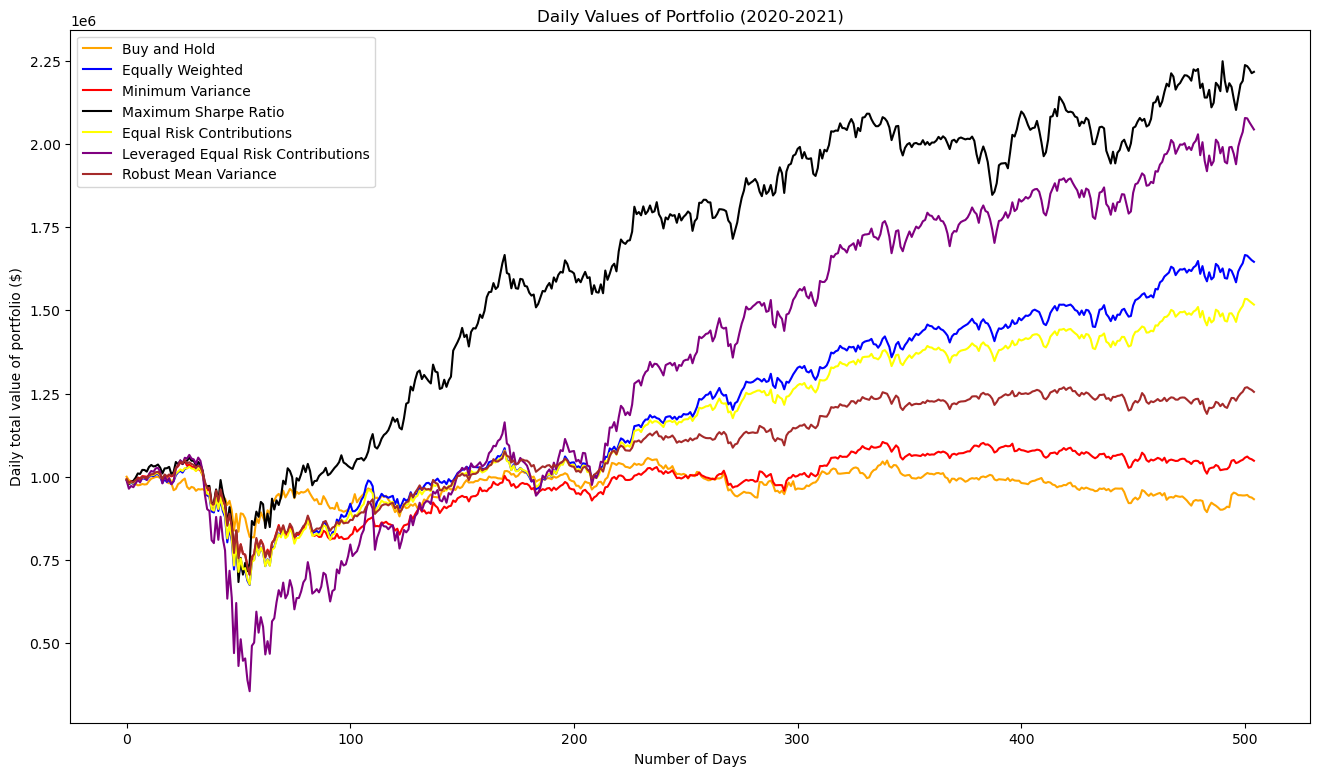

In [12]:
plt.figure(figsize=(16,9))
plt.plot(portf_value[0], label='Buy and Hold', color='orange')
plt.plot(portf_value[1], label='Equally Weighted', color='blue')
plt.plot(portf_value[2], label='Minimum Variance', color='red')
plt.plot(portf_value[3], label='Maximum Sharpe Ratio', color='black')
plt.plot(portf_value[4],label='Equal Risk Contributions', color = 'yellow')
plt.plot(portf_value[5],label='Leveraged Equal Risk Contributions', color = 'purple')
plt.plot(portf_value[6],label='Robust Mean Variance', color = 'brown')
plt.title('Daily Values of Portfolio (2020-2021)')
plt.xlabel('Number of Days')
plt.ylabel('Daily total value of portfolio ($)')
plt.legend()
plt.show()

## Maximum Drawdown of the Portfolio

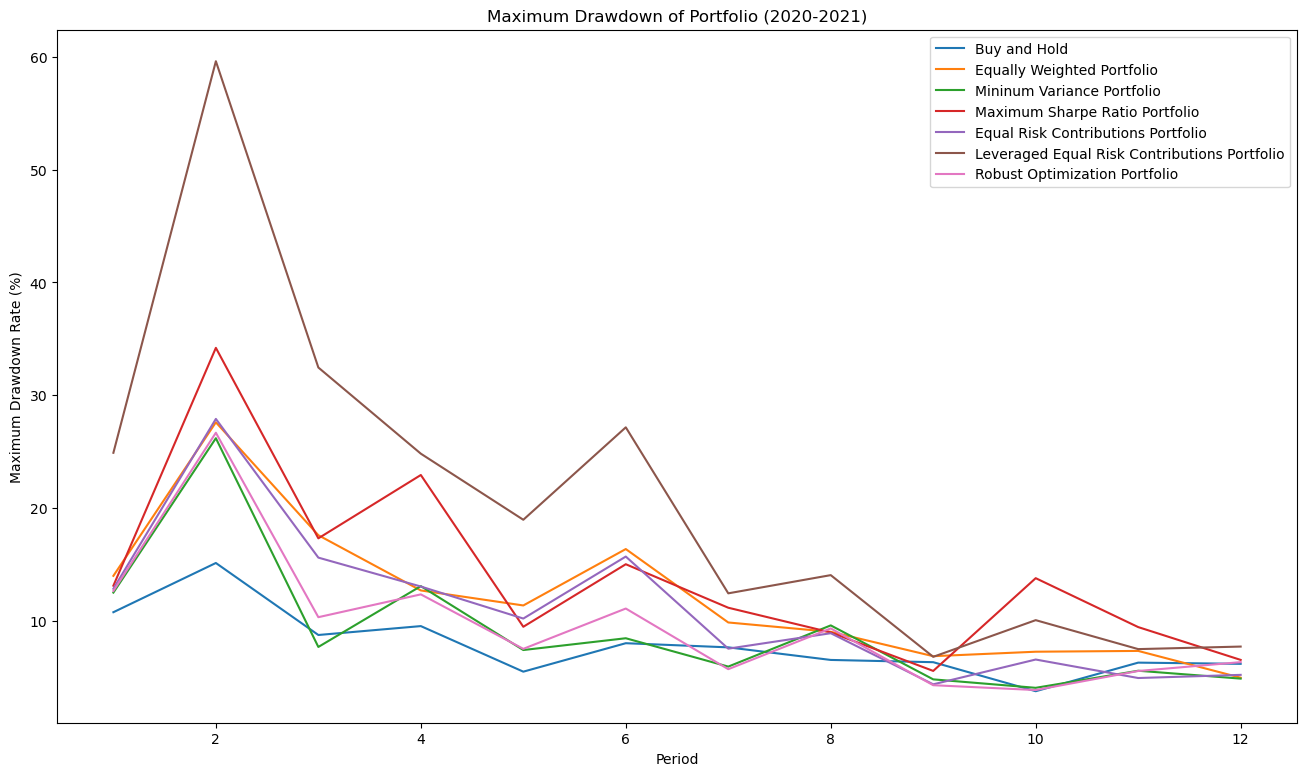

In [13]:
Daily_strategy7 = pd.DataFrame({strategy_names[i]: portf_value[i].flatten() for i in range(7)})
periods_split = [0]
for period in range(1, 13):
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 20:
        cur_year  = 20 + math.floor(period/7)
    else:
        cur_year  = 2020 + math.floor(period/7)
    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    periods_split.append(int(df[df.Date == dates[day_ind_start]].index.values + 1))
df_maxdd = pd.DataFrame({strategy_names[i]: 0 for i in range(7)}, index=range(1, 13))
for i in range(12):
    maximum_dd = []
    for j in range(7):
        df_periods = Daily_strategy7.iloc[periods_split[i] : periods_split[i + 1]]
        df_strategy = df_periods.loc[:, strategy_names[j]]
        dd_rate = ((df_strategy - df_strategy.max())/df_strategy.max()) * 100
        maxdd_rate = dd_rate.abs().max()
        maximum_dd.append(maxdd_rate)
    df_maxdd.iloc[i] = maximum_dd
df_maxdd.plot(figsize = (16, 9))
plt.title('Maximum Drawdown of Portfolio (2020-2021)')
plt.xlabel('Period')
plt.ylabel('Maximum Drawdown Rate (%)')
plt.show()

## Plot dynamic changes in Portfolio Allocations

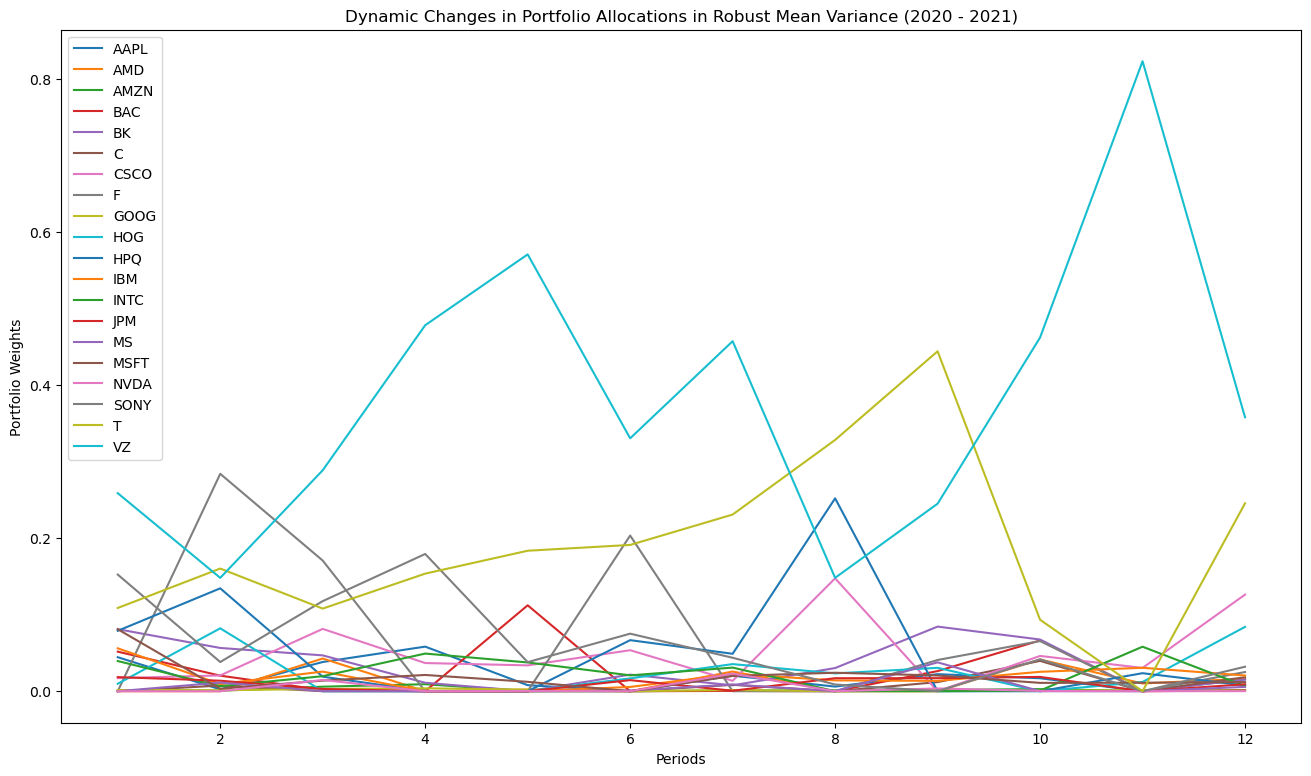

In [14]:
#Plot dynamic Changes in portfolio allocations for Robust Mean Variance
stock_name = df.columns[1:]
w_robust_mv = []
for period in range(1, N_periods+1):
    w_robust_mv.append(x[6, period-1]/sum(x[6, period-1]))
df_robust_mean_variance = pd.DataFrame(w_robust_mv, columns=stock_name, index=[1,2,3,4,5,6,7,8,9,10,11,12])
df_robust_mean_variance.plot(figsize=(16,9))
plt.title('Dynamic Changes in Portfolio Allocations in Robust Mean Variance (2020 - 2021)')
plt.xlabel('Periods')
plt.ylabel('Portfolio Weights')
plt.show()

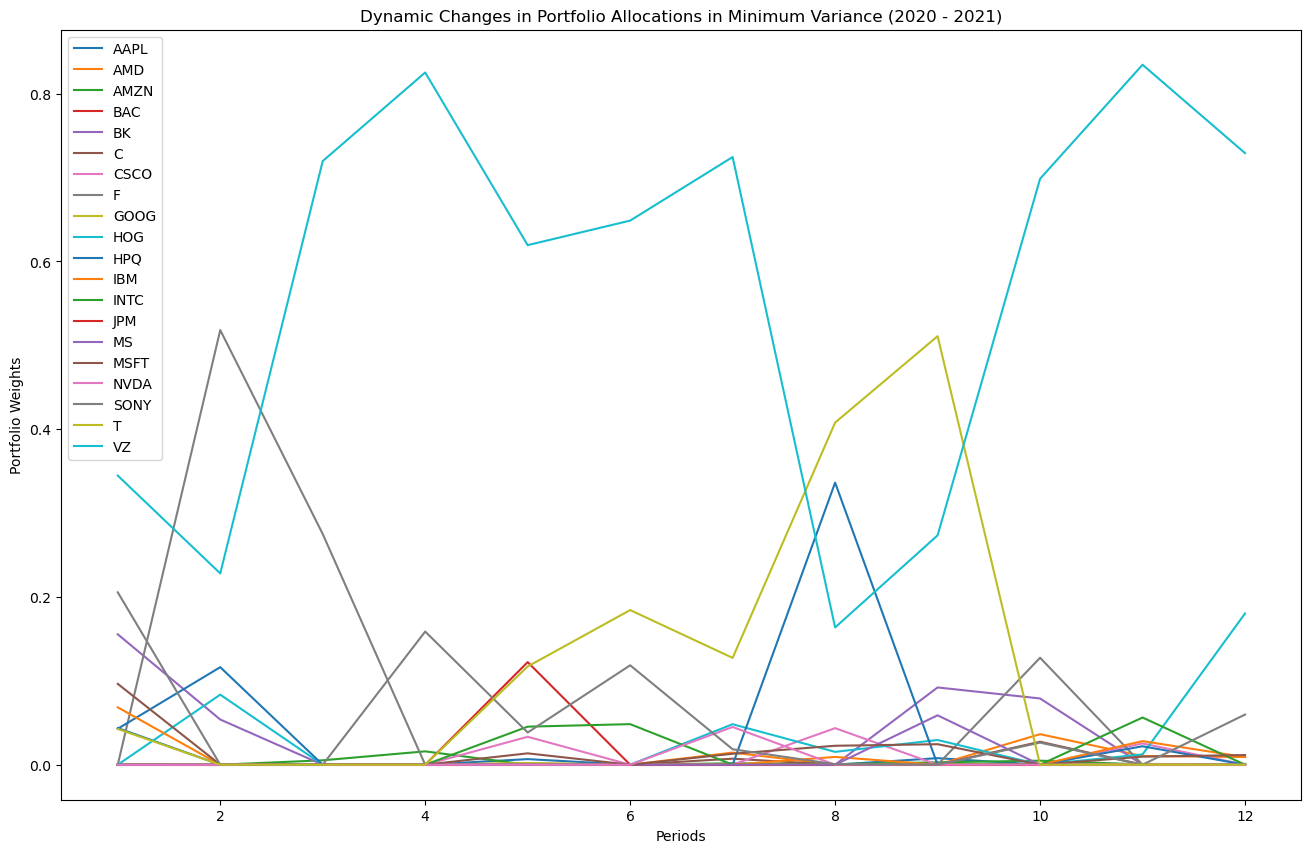

In [15]:
#Plot dynamic Changes in portfolio allocations for minimum variance in Assignment 1
stock_name = df.columns[1:]
w_min= []
for period in range(1, N_periods+1):
    w_min.append(x[2, period-1]/sum(x[2, period-1]))
df_min_variance = pd.DataFrame(w_min, columns=stock_name, index=[1,2,3,4,5,6,7,8,9,10,11,12])
df_min_variance.plot(figsize=(16,10))
plt.title('Dynamic Changes in Portfolio Allocations in Minimum Variance (2020 - 2021)')
plt.xlabel('Periods')
plt.ylabel('Portfolio Weights')
plt.show()

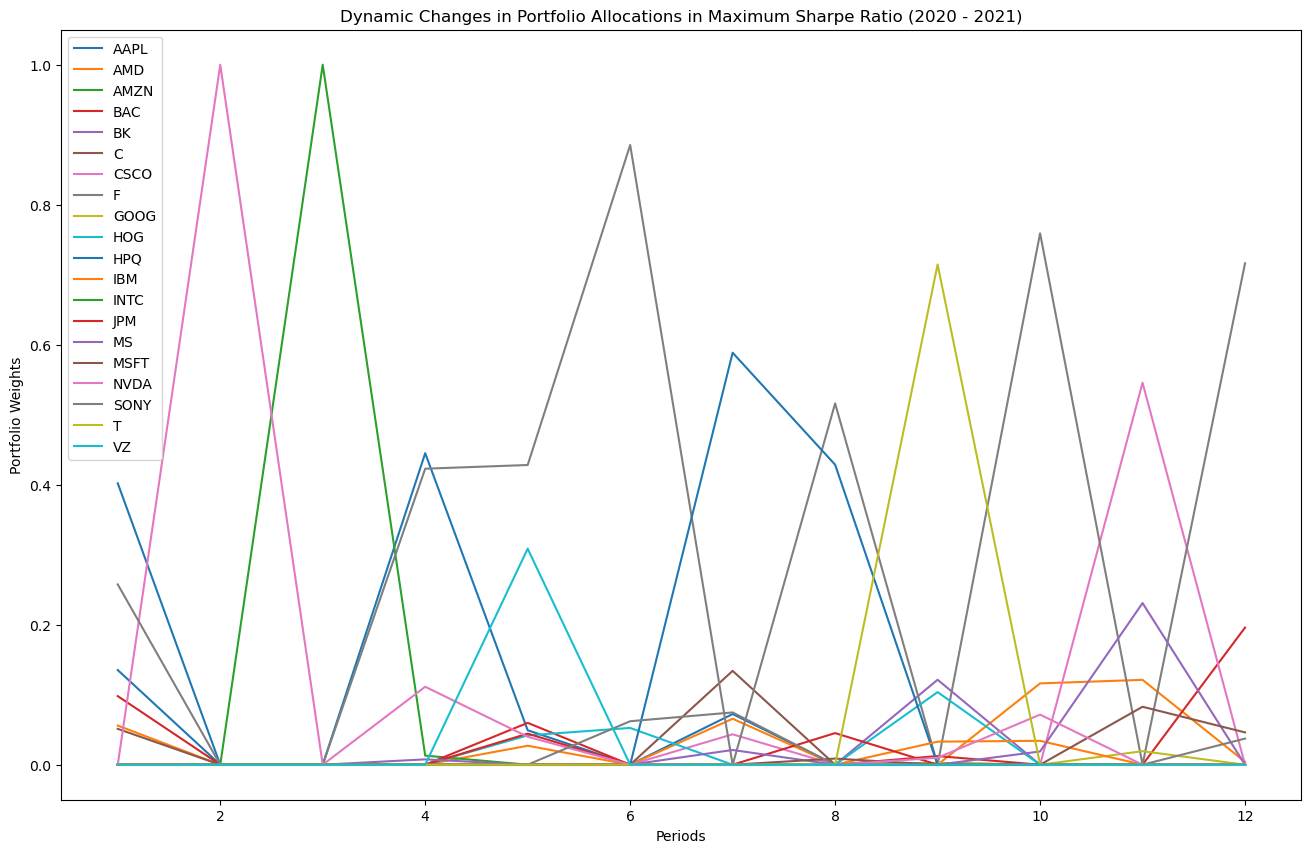

In [16]:
#Plot dynamic Changes in portfolio allocations for Maximum Sharpe Ratio in Assignment 1
stock_name = df.columns[1:]
w_max_sharpe = []
for period in range(1, N_periods+1):
    w_max_sharpe.append(x[3, period-1]/sum(x[3, period-1]))
df_max_sharpe = pd.DataFrame(w_max_sharpe, columns=stock_name, index=[1,2,3,4,5,6,7,8,9,10,11,12])
df_max_sharpe.plot(figsize=(16,10))
plt.title('Dynamic Changes in Portfolio Allocations in Maximum Sharpe Ratio (2020 - 2021)')
plt.xlabel('Periods')
plt.ylabel('Portfolio Weights')
plt.show()